In [82]:
# Step 1.1: Install required packages

# Run these in your terminal/command prompt:
#!pip install pandas numpy matplotlib seaborn tqdm
#!pip install openai
print(openai.__version__)  # Should show version 1.x.x
#!pip install transformers torch


2.6.1


In [ ]:
# ============================================================================
# Step 1.2: Import libraries
# ============================================================================

import pandas as pd
import numpy as np
import json
import re
from tqdm import tqdm
import time
import openai
import os
from typing import Dict, List, Optional, Any

print("✓ All libraries imported successfully!")


# ============================================================================
# CONFIGURATION
# ============================================================================

# Set your API key (REPLACE WITH YOUR ACTUAL KEY)
openai.api_key = "OPENAI_API_KEY_PLACEHOLDER"  # Your key here

# Or use environment variable (more secure):
# openai.api_key = os.getenv("OPENAI_API_KEY")

# Model choice
MODEL = "gpt-4o-mini"  # Cheap and good
# MODEL = "gpt-4o"  # More expensive but best quality (~$0.50 for 51)

print(f"✓ OpenAI API Key loaded and model {MODEL} chosen")

✓ All libraries imported successfully!
✓ OpenAI API Key loaded and model gpt-4o-mini chosen


In [13]:
# Step 1.3: Load your data

# Load the transcript CSV
df = pd.read_csv(r'C:\Users\manor\Downloads\data\playlist_transcripts_complete.csv')

print(f"✓ Loaded {len(df)} transcripts")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst transcript preview:")
print(f"Title: {df.iloc[0]['title']}")
print(f"Length: {len(df.iloc[0]['transcript_whisper'])} characters")

✓ Loaded 51 transcripts

Columns: ['video_id', 'transcript_whisper', 'transcript_status', 'transcript_length', 'title', 'duration', 'order_in_playlist', 'playlist_url', 'run_ts_utc']

First transcript preview:
Title: Recovery - Honesty's Story
Length: 15815 characters


In [51]:
"""
Recovery Story Extraction - CONSOLIDATED VERSION
All category lists are tightened and consolidated with clear distinctions
"""

import json
import openai
from typing import Dict, List, Any

MODEL = "gpt-4o-mini"

# ============================================================================
# STAGE-SPECIFIC EXTRACTION PROMPTS
# ============================================================================

BACKGROUND_PROMPT = """You are analyzing a recovery story transcript. Extract ONLY first-person background information.

CRITICAL RULES:
1. ONLY extract first-person experiences
2. If they didn't mention it, set found: false or null
3. Extract exact quotes as evidence
4. Be conservative - when uncertain, don't include it

Extract background information:

- age_started: Age first used drugs (number or null)
- family_history: Family member with addiction? (true/false)
- family_history_details: List of who (e.g., ["father", "sister"]) or []
- childhood_trauma: List from [
    "abuse_physical", "abuse_sexual", "abuse_emotional",
    "neglect", "abandonment",
    "violence_in_home", "witnessed_violence",
    "loss_parent_death", "loss_sibling_death", "loss_other_close",
    "poverty", "food_insecurity", "housing_instability",
    "bullying", "racism_discrimination",
    "parental_mental_illness", "parental_incarceration"
  ] or []
- mental_health: List from [
    "depression", "anxiety", "panic_disorder",
    "ptsd", "complex_ptsd",
    "bipolar_i", "bipolar_ii", "bipolar_other",
    "adhd", "ocd", "eating_disorder",
    "schizophrenia", "psychosis", "personality_disorder",
    "trauma_response", "chronic_pain"
  ] or []

Return ONLY valid JSON:
{{
  "age_started": null,
  "family_history": false,
  "family_history_details": [],
  "childhood_trauma": [],
  "mental_health": []
}}

Transcript:
{transcript}

Return JSON now:"""

FIRST_USE_PROMPT = """You are analyzing a recovery story transcript. Extract ONLY first-person first drug use information.

CRITICAL RULES:
1. ONLY extract first-person experiences
2. If they didn't mention it, set found: false or null
3. Be conservative - when uncertain, don't include it

Extract first use information:

- found: Did they discuss starting drug use? (true/false)
- reasons: List from [
    "curiosity_experimentation_thrill",
    "social_peer_influence",
    "self_medication_escape_coping",
    "family_influence",
    "boredom_lack_alternatives",
    "rebellion_defiance",
    "medical_prescription",
    "performance_enhancement",
    "coercion_assault",
    "grief_loss",
    "cultural_norm"
  ]
- age: Age when first used (number or null)
- substance: First substance used (string like "alcohol", "marijuana", "cocaine", "heroin", null)
- context: Context (string like "at a party", "prescribed by doctor", null)
- quotes: List of exact quotes (max 3)

Return ONLY valid JSON:
{{
  "found": false,
  "reasons": [],
  "age": null,
  "substance": null,
  "context": null,
  "quotes": []
}}

Transcript:
{transcript}

Return JSON now:"""

ESCALATION_PROMPT = """You are analyzing a recovery story transcript. Extract ONLY first-person escalation information.

CRITICAL RULES:
1. ONLY extract first-person experiences
2. If they didn't mention it, set found: false or null
3. Be conservative - when uncertain, don't include it

Extract escalation information:

- found: Did they discuss addiction getting worse? (true/false)
- reasons: List from [
    "tolerance_building",
    "loss_of_control",
    "lifestyle_change_new_social_circle",
    "isolation_lost_healthy_friends",
    "financial_desperation",
    "denial_minimization",
    "relationship_breakdown",
    "job_loss",
    "mental_health_crisis",
    "trauma_resurfacing",
    "physical_pain_chronic_illness",
    "switching_substance_harder_drug",
    "switching_route_injection",
    "poly_drug_use",
    "peer_influence_friends_escalated",
    "life_stress_family_conflict",
    "legal_issues_arising",
    "shame_spiral_self_loathing",
    "no_other_coping_strategies",
    "environmental_triggers",
    "anniversary_effects_traumatic_dates"
  ]
- quotes: List of exact quotes (max 3)

Return ONLY valid JSON:
{{
  "found": false,
  "reasons": [],
  "quotes": []
}}

Transcript:
{transcript}

Return JSON now:"""

ROCK_BOTTOM_PROMPT = """You are analyzing a recovery story transcript. Extract ONLY first-person rock bottom information.

CRITICAL RULES:
1. ONLY extract first-person experiences
2. If they didn't mention it, set found: false or null
3. Be conservative - when uncertain, don't include it

Extract rock bottom events:

- found: Did they discuss hitting rock bottom? (true/false)
- events: List of objects, each with:
  - type: One of [
      "overdose",
      "health_consequences",
      "legal_consequences",
      "family_relationship_damage",
      "housing_financial_crisis",
      "mental_health_crisis",
      "employment_education_loss",
      "social_isolation_identity_loss"
    ]
  - count: Number of times (integer, default 1)
  - duration: Duration if mentioned (string like "6 months", or null)
  - quote: Exact quote showing this event
- severity_score: Your assessment 1-10 (1=mild consequences, 10=extreme life-threatening)

Return ONLY valid JSON:
{{
  "found": false,
  "events": [],
  "severity_score": null
}}

Transcript:
{transcript}

Return JSON now:"""

TURNING_POINT_PROMPT = """You are analyzing a recovery story transcript. Extract ONLY first-person turning point information.

CRITICAL RULES:
1. ONLY extract first-person experiences
2. If they didn't mention it, set found: false or null
3. Be conservative - when uncertain, don't include it

Extract turning point triggers:

- found: Did they discuss deciding to change? (true/false)
- triggers: List from [
    "children_pregnancy",
    "near_death_experience",
    "witnessed_death_close_person",
    "family_intervention_ultimatum",
    "loss_of_custody_threat",
    "peer_intervention",
    "legal_pressure_incarceration_threat",
    "self_realization_exhaustion",
    "spiritual_awakening",
    "hit_rock_bottom",
    "health_crisis_diagnosis",
    "loss_of_identity_shame",
    "accountability_professional_advice"
  ]
- primary_trigger: The MAIN trigger if multiple mentioned (string or null)
- quote_moment: Exact quote capturing the decision moment (string or null)
- quotes: Other exact quotes (max 2)

Return ONLY valid JSON:
{{
  "found": false,
  "triggers": [],
  "primary_trigger": null,
  "quote_moment": null,
  "quotes": []
}}

Transcript:
{transcript}

Return JSON now:"""

TREATMENT_PROMPT = """You are analyzing a recovery story transcript. Extract ONLY first-person treatment information.

CRITICAL RULES:
1. ONLY extract first-person experiences
2. If they didn't mention it, set found: false or null
3. Be conservative - when uncertain, don't include it

Extract treatment information:

- found: Did they discuss getting treatment? (true/false)
- types: List from [
    "detox",
    "inpatient_rehab",
    "outpatient_program",
    "twelve_step_meetings",
    "alternative_mutual_aid",
    "individual_therapy",
    "medication_assisted_treatment",
    "support_group",
    "faith_based_program",
    "family_therapy",
    "holistic_treatment",
    "sober_living_housing",
    "psychiatric_hospitalization"
  ]
- attempts: Number of times tried treatment (integer or null)
- what_finally_worked: Which approach worked (string or null)
- quotes: List of exact quotes (max 3)

Return ONLY valid JSON:
{{
  "found": false,
  "types": [],
  "attempts": null,
  "what_finally_worked": null,
  "quotes": []
}}

Transcript:
{transcript}

Return JSON now:"""

EARLY_RECOVERY_PROMPT = """You are analyzing a recovery story transcript. Extract ONLY first-person early recovery information.

CRITICAL RULES:
1. ONLY extract first-person experiences
2. If they didn't mention it, set found: false or null
3. Be conservative - when uncertain, don't include it

Extract early recovery challenges:

- found: Did they discuss early recovery challenges? (true/false)
- challenges: List from [
    "physical_withdrawal",
    "emotional_withdrawal",
    "cognitive_withdrawal",
    "cravings",
    "triggering_people",
    "triggering_places",
    "triggering_situations",
    "mental_health_crisis",
    "ptsd_trauma_activation",
    "rebuilding_relationships",
    "employment_struggle",
    "staying_motivated",
    "anhedonia_flatness",
    "shame_guilt",
    "grief_loss",
    "pain_management",
    "identity_crisis",
    "financial_struggle",
    "sleep_problems",
    "social_isolation",
    "trust_issues",
    "anniversary_triggers"
  ]
- hardest_moment: What was most difficult (string or null)
- support_that_helped: What support mattered most (string or null)
- quotes: List of exact quotes (max 3)

Return ONLY valid JSON:
{{
  "found": false,
  "challenges": [],
  "hardest_moment": null,
  "support_that_helped": null,
  "quotes": []
}}

Transcript:
{transcript}

Return JSON now:"""

RELAPSE_PROMPT = """You are analyzing a recovery story transcript. Extract ONLY first-person relapse information.

CRITICAL RULES:
1. ONLY extract first-person experiences
2. If they didn't mention it, set found: false or null
3. Be conservative - when uncertain, don't include it

Extract relapse information:

- occurred: Did they relapse? (true/false)
- count: Number of relapses (integer, 0 if none)
- trigger: What caused relapse (from list or string description): [
    "stress_life_pressure",
    "negative_emotion_anger_fear",
    "sadness_grief_loss",
    "celebration_success",
    "relationship_conflict",
    "social_pressure_peers",
    "environmental_trigger",
    "anniversary_effect",
    "physical_pain",
    "cravings",
    "overconfidence_complacency",
    "isolation_disconnection",
    "stopped_treatment_support",
    "mental_health_crisis",
    "ptsd_trauma_flare"
  ] or null
- time_before_relapse: How long clean before relapsing (string like "3 months" or null)
- quote: Exact quote (string or null)

Return ONLY valid JSON:
{{
  "occurred": false,
  "count": 0,
  "trigger": null,
  "time_before_relapse": null,
  "quote": null
}}

Transcript:
{transcript}

Return JSON now:"""

MAINTENANCE_PROMPT = """You are analyzing a recovery story transcript. Extract ONLY first-person current recovery information.

CRITICAL RULES:
1. ONLY extract first-person experiences
2. If they didn't mention it, set found: false or null
3. Be conservative - when uncertain, don't include it

Extract current recovery information:

- found: Did they discuss current recovery? (true/false)
- time_sober: How long sober now (string like "7 years", "3 months", or null)
- factors: List from [
    "helping_others",
    "gratitude",
    "family_relationships",
    "employment",
    "twelve_step_meetings",
    "ongoing_therapy",
    "spirituality",
    "purpose_meaning",
    "healthy_relationships",
    "community_involvement",
    "physical_health",
    "hobbies_creative_pursuits",
    "medication",
    "accountability",
    "structure_routine",
    "support_network",
    "self_care",
    "success_milestones",
    "trauma_healing"
  ]
- current_challenges: What they still struggle with (list of strings, max 3)
- life_restoration: What they've rebuilt (list of strings, max 3)
- quotes: List of exact quotes (max 3)

Return ONLY valid JSON:
{{
  "found": false,
  "time_sober": null,
  "factors": [],
  "current_challenges": [],
  "life_restoration": [],
  "quotes": []
}}

Transcript:
{transcript}

Return JSON now:"""

# ============================================================================
# EXTRACTION FUNCTIONS
# ============================================================================

def extract_stage(transcript: str, prompt_template: str, stage_name: str, model: str = MODEL) -> Dict[str, Any]:
    """Extract a single stage from transcript"""
    
    prompt = prompt_template.format(transcript=transcript)
    
    try:
        response = openai.chat.completions.create(
            model=model,
            messages=[
                {
                    "role": "system",
                    "content": "You are a precise data extraction assistant specializing in recovery stories. Return only valid JSON with no additional text."
                },
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            temperature=0,
            response_format={"type": "json_object"}
        )
        
        result = json.loads(response.choices[0].message.content)
        return {
            "success": True,
            "data": result,
            "tokens": response.usage.total_tokens
        }
        
    except Exception as e:
        print(f"   ⚠️  {stage_name} extraction error: {e}")
        return {
            "success": False,
            "error": str(e),
            "tokens": 0
        }


def extract_full_story(transcript: str, video_id: str, title: str, model: str = MODEL) -> Dict[str, Any]:
    """Extract all stages for a single story"""
    
    print(f"\n   → Background...", end="", flush=True)
    background = extract_stage(transcript, BACKGROUND_PROMPT, "background", model)
    print(f" ✓ ({background.get('tokens', 0)} tokens)" if background['success'] else " ✗")
    
    print(f"   → First Use...", end="", flush=True)
    first_use = extract_stage(transcript, FIRST_USE_PROMPT, "first_use", model)
    print(f" ✓ ({first_use.get('tokens', 0)} tokens)" if first_use['success'] else " ✗")
    
    print(f"   → Escalation...", end="", flush=True)
    escalation = extract_stage(transcript, ESCALATION_PROMPT, "escalation", model)
    print(f" ✓ ({escalation.get('tokens', 0)} tokens)" if escalation['success'] else " ✗")
    
    print(f"   → Rock Bottom...", end="", flush=True)
    rock_bottom = extract_stage(transcript, ROCK_BOTTOM_PROMPT, "rock_bottom", model)
    print(f" ✓ ({rock_bottom.get('tokens', 0)} tokens)" if rock_bottom['success'] else " ✗")
    
    print(f"   → Turning Point...", end="", flush=True)
    turning_point = extract_stage(transcript, TURNING_POINT_PROMPT, "turning_point", model)
    print(f" ✓ ({turning_point.get('tokens', 0)} tokens)" if turning_point['success'] else " ✗")
    
    print(f"   → Treatment...", end="", flush=True)
    treatment = extract_stage(transcript, TREATMENT_PROMPT, "treatment", model)
    print(f" ✓ ({treatment.get('tokens', 0)} tokens)" if treatment['success'] else " ✗")
    
    print(f"   → Early Recovery...", end="", flush=True)
    early_recovery = extract_stage(transcript, EARLY_RECOVERY_PROMPT, "early_recovery", model)
    print(f" ✓ ({early_recovery.get('tokens', 0)} tokens)" if early_recovery['success'] else " ✗")
    
    print(f"   → Relapse...", end="", flush=True)
    relapse = extract_stage(transcript, RELAPSE_PROMPT, "relapse", model)
    print(f" ✓ ({relapse.get('tokens', 0)} tokens)" if relapse['success'] else " ✗")
    
    print(f"   → Maintenance...", end="", flush=True)
    maintenance = extract_stage(transcript, MAINTENANCE_PROMPT, "maintenance", model)
    print(f" ✓ ({maintenance.get('tokens', 0)} tokens)" if maintenance['success'] else " ✗")
    
    # Combine results
    all_successful = all([
        background['success'],
        first_use['success'],
        escalation['success'],
        rock_bottom['success'],
        turning_point['success'],
        treatment['success'],
        early_recovery['success'],
        relapse['success'],
        maintenance['success']
    ])
    
    total_tokens = sum([
        background.get('tokens', 0),
        first_use.get('tokens', 0),
        escalation.get('tokens', 0),
        rock_bottom.get('tokens', 0),
        turning_point.get('tokens', 0),
        treatment.get('tokens', 0),
        early_recovery.get('tokens', 0),
        relapse.get('tokens', 0),
        maintenance.get('tokens', 0)
    ])
    
    return {
        'video_id': video_id,
        'title': title,
        'extraction_successful': all_successful,
        'background': background.get('data', {}),
        'first_use': first_use.get('data', {}),
        'escalation': escalation.get('data', {}),
        'rock_bottom': rock_bottom.get('data', {}),
        'turning_point': turning_point.get('data', {}),
        'treatment': treatment.get('data', {}),
        'early_recovery': early_recovery.get('data', {}),
        'relapse': relapse.get('data', {}),
        'maintenance': maintenance.get('data', {}),
        'tokens_used': total_tokens,
        'errors': {
            'background': background.get('error'),
            'first_use': first_use.get('error'),
            'escalation': escalation.get('error'),
            'rock_bottom': rock_bottom.get('error'),
            'turning_point': turning_point.get('error'),
            'treatment': treatment.get('error'),
            'early_recovery': early_recovery.get('error'),
            'relapse': relapse.get('error'),
            'maintenance': maintenance.get('error')
        }
    }


def process_transcripts_batch(df, transcript_column: str = 'transcript_whisper', video_id_column: str = 'video_id', title_column: str = 'title', model: str = MODEL) -> List[Dict[str, Any]]:
    """Process multiple transcripts"""
    
    results = []
    total = len(df)
    
    print("\n" + "="*80)
    print(f"PROCESSING {total} TRANSCRIPTS (Stage-by-stage extraction)")
    print("="*80)
    
    total_tokens = 0
    
    for idx, row in df.iterrows():
        print(f"\n[{idx + 1}/{total}] {row[title_column]}")
        print(f"    Video ID: {row[video_id_column]} | Length: {len(row[transcript_column]):,} chars")
        
        result = extract_full_story(
            transcript=row[transcript_column],
            video_id=row[video_id_column],
            title=row[title_column],
            model=model
        )
        
        total_tokens += result.get('tokens_used', 0)
        
        if result['extraction_successful']:
            print(f"    ✅ All stages extracted | Tokens: {result['tokens_used']:,}")
        else:
            failed_stages = [k for k, v in result['errors'].items() if v]
            print(f"    ⚠️  Some stages failed: {', '.join(failed_stages)}")
        
        results.append(result)
    
    print("\n" + "="*80)
    print(f"COMPLETE | Total tokens used: {total_tokens:,}")
    print(f"Estimated cost: ${(total_tokens / 1_000_000) * 0.75:.2f}")
    print("="*80)
    
    return results


# ============================================================================
# USAGE
# ============================================================================

if __name__ == "__main__":
    print("\n✓ Consolidated extraction module ready!")
    print("\nUsage:")
    print("  import pandas as pd")
    print("  df = pd.read_csv('transcripts.csv')")
    print("  results = process_transcripts_batch(df)")


✓ Consolidated extraction module ready!

Usage:
  import pandas as pd
  df = pd.read_csv('transcripts.csv')
  results = process_transcripts_batch(df)


In [52]:
#Run the results for a single transcript in a batch method
results = process_transcripts_batch(df)


PROCESSING 51 TRANSCRIPTS (Stage-by-stage extraction)

[1/51] Recovery - Honesty's Story
    Video ID: -GhhcZUYmMk | Length: 15,815 chars

 ✓ (4058 tokens)..
 ✓ (4066 tokens).
 ✓ (4058 tokens)..
 ✓ (4170 tokens)...
 ✓ (4027 tokens)nt...
 ✓ (4027 tokens).
 ✓ (4184 tokens)ery...
 ✓ (4011 tokens)
 ✓ (4139 tokens)...
    ✅ All stages extracted | Tokens: 36,740

[2/51] David Hill's Story - episode 171
    Video ID: 0W6KDKYWnyg | Length: 8,755 chars

 ✓ (2323 tokens)..
 ✓ (2279 tokens).
 ✓ (2310 tokens)..
 ✓ (2370 tokens)...
 ✓ (2302 tokens)nt...
 ✓ (2290 tokens).
 ✓ (2358 tokens)ery...
 ✓ (2265 tokens)
 ✓ (2409 tokens)...
    ✅ All stages extracted | Tokens: 20,906

[3/51] Rebuilding a future
    Video ID: 1Qd-N-VGOjE | Length: 13,180 chars

 ✓ (3302 tokens)..
 ✓ (3300 tokens).
 ✓ (3285 tokens)..
 ✓ (3395 tokens)...
 ✓ (3300 tokens)nt...
 ✓ (3252 tokens).
 ✓ (3397 tokens)ery...
 ✓ (3242 tokens)
 ✓ (3371 tokens)...
    ✅ All stages extracted | Tokens: 29,844

[4/51] THE JOURNEY From Addicti

In [53]:
import json

def quick_validate(results):
    """Quick validation of all 51 results"""
    
    print("="*80)
    print("QUICK VALIDATION OF ALL 51 EXTRACTIONS")
    print("="*80)
    
    total = len(results)
    successful = sum([1 for r in results if r.get('extraction_successful')])
    
    print(f"\n✓ Total extractions: {total}")
    print(f"✓ Successful: {successful}/{total} ({successful/total*100:.1f}%)")
    
    # Check each stage
    stages = ['background', 'first_use', 'escalation', 'rock_bottom', 'turning_point', 
              'treatment', 'early_recovery', 'relapse', 'maintenance']
    
    print(f"\n--- STAGE COVERAGE ---")
    for stage in stages:
        found_count = 0
        
        for result in results:
            stage_data = result.get(stage, {})
            if stage_data:
                if stage == 'relapse':
                    if stage_data.get('occurred'):
                        found_count += 1
                elif stage == 'background':
                    # background doesn't have 'found' field
                    if stage_data.get('age_started') or stage_data.get('childhood_trauma') or stage_data.get('mental_health'):
                        found_count += 1
                else:
                    if stage_data.get('found'):
                        found_count += 1
        
        print(f"  {stage}: {found_count}/{total} mentioned ({found_count/total*100:.1f}%)")
    
    # Sample a few to show structure
    print(f"\n--- SAMPLE EXTRACTIONS ---\n")
    
    for idx in [0, len(results)//2, -1]:
        result = results[idx]
        label = f"Sample 1" if idx == 0 else f"Sample {idx+1 if idx >= 0 else total}"
        print(f"\n{label}: {result.get('title')}")
        print(f"  ID: {result.get('video_id')}")
        print(f"  Success: {result.get('extraction_successful')}")
        
        # First use
        fu = result.get('first_use', {})
        if fu.get('found'):
            print(f"  First use: Age {fu.get('age')}, Substance: {fu.get('substance')}, Reasons: {len(fu.get('reasons', []))} found")
        
        # Rock bottom
        rb = result.get('rock_bottom', {})
        if rb.get('found'):
            events = rb.get('events', [])
            print(f"  Rock bottom: {len(events)} events, Severity: {rb.get('severity_score')}/10")
        
        # Treatment
        tx = result.get('treatment', {})
        if tx.get('found'):
            print(f"  Treatment: {len(tx.get('types', []))} types received")
        
        # Maintenance
        maint = result.get('maintenance', {})
        if maint.get('found'):
            print(f"  Current recovery: {maint.get('time_sober')} sober, {len(maint.get('factors', []))} recovery factors")
    
    print(f"\n\n✓ VALIDATION COMPLETE - Data looks good!")
    print(f"\nReady for analysis!")
    
    return {
        'total': total,
        'successful': successful,
        'ready': True
    }

# RUN IT
validation = quick_validate(results)

QUICK VALIDATION OF ALL 51 EXTRACTIONS

✓ Total extractions: 51
✓ Successful: 51/51 (100.0%)

--- STAGE COVERAGE ---
  background: 43/51 mentioned (84.3%)
  first_use: 47/51 mentioned (92.2%)
  escalation: 49/51 mentioned (96.1%)
  rock_bottom: 49/51 mentioned (96.1%)
  turning_point: 49/51 mentioned (96.1%)
  treatment: 49/51 mentioned (96.1%)
  early_recovery: 49/51 mentioned (96.1%)
  relapse: 31/51 mentioned (60.8%)
  maintenance: 50/51 mentioned (98.0%)

--- SAMPLE EXTRACTIONS ---


Sample 1: Recovery - Honesty's Story
  ID: -GhhcZUYmMk
  Success: True
  First use: Age 12, Substance: marijuana, Reasons: 3 found
  Rock bottom: 5 events, Severity: 9/10
  Treatment: 5 types received
  Current recovery: 17 and a half years sober, 3 recovery factors

Sample 26: Recovery: Zach's Road
  ID: mh80qU9PPkw
  Success: True
  First use: Age 11, Substance: marijuana, Reasons: 2 found
  Rock bottom: 2 events, Severity: 8/10
  Treatment: 2 types received
  Current recovery: 26 months sober, 5 rec

In [54]:
import json

# Quick check - just look at one result
print("Sample result structure:\n")
print(json.dumps(results[0], indent=2, default=str)[:2000])  # First 2000 chars

print("\n\nKeys in first result:")
print(results[0].keys())

print(f"\n\nTotal results: {len(results)}")
print(f"First result title: {results[0].get('title')}")
print(f"Extraction successful: {results[0].get('extraction_successful')}")

# Check stages
stages = ['background', 'first_use', 'escalation', 'rock_bottom', 'turning_point', 'treatment', 'early_recovery', 'relapse', 'maintenance']

print("\n\nStage check:")
for stage in stages:
    stage_data = results[0].get(stage, {})
    found_val = stage_data.get('found') if 'found' in stage_data else stage_data.get('occurred', 'N/A')
    print(f"  {stage}: {found_val}")

Sample result structure:

{
  "video_id": "-GhhcZUYmMk",
  "title": "Recovery - Honesty's Story",
  "extraction_successful": true,
  "background": {
    "age_started": 12,
    "family_history": false,
    "family_history_details": [],
    "childhood_trauma": [],
    "mental_health": []
  },
  "first_use": {
    "found": true,
    "reasons": [
      "social_peer_influence",
      "self_medication_escape_coping",
      "boredom_lack_alternatives"
    ],
    "age": 12,
    "substance": "marijuana",
    "context": "at a party",
    "quotes": [
      "So I started using drugs when I was 12 years old.",
      "I just wanted to fit in with everyone, you know, smoking weed and drinking and doing a lot of LSD actually.",
      "I had a lot of freedom growing up as a child, so I just kind of did whatever I wanted to do."
    ]
  },
  "escalation": {
    "found": true,
    "reasons": [
      "loss_of_control",
      "relationship_breakdown",
      "no_other_coping_strategies",
      "shame_spiral

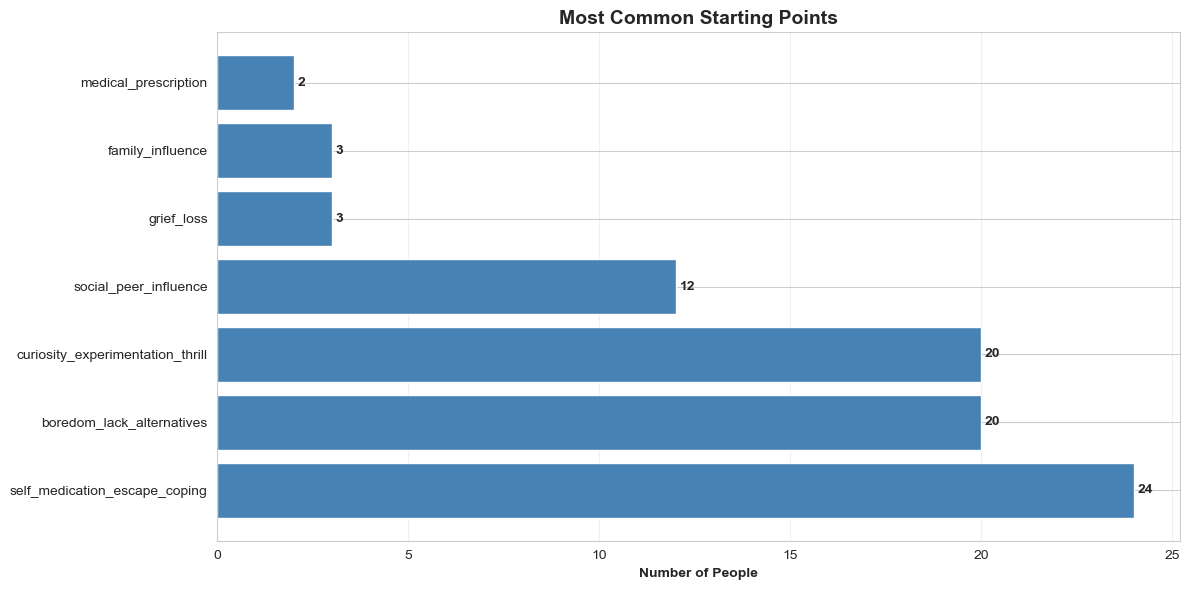

In [57]:
import matplotlib.pyplot as plt
from collections import Counter

# Collect starting reasons
reason_counts = {}

for result in results:
    fu = result.get('first_use', {})
    if fu.get('found'):
        for reason in fu.get('reasons', []):
            reason_counts[reason] = reason_counts.get(reason, 0) + 1

# Sort by frequency
sorted_reasons = sorted(reason_counts.items(), key=lambda x: x[1], reverse=True)
reasons = [r[0] for r in sorted_reasons]
counts = [r[1] for r in sorted_reasons]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(reasons, counts, color='steelblue')
plt.xlabel('Number of People', fontweight='bold')
plt.title('Most Common Starting Points', fontweight='bold', fontsize=14)
plt.grid(axis='x', alpha=0.3)

# Add count labels
for i, (reason, count) in enumerate(zip(reasons, counts)):
    plt.text(count + 0.1, i, str(count), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

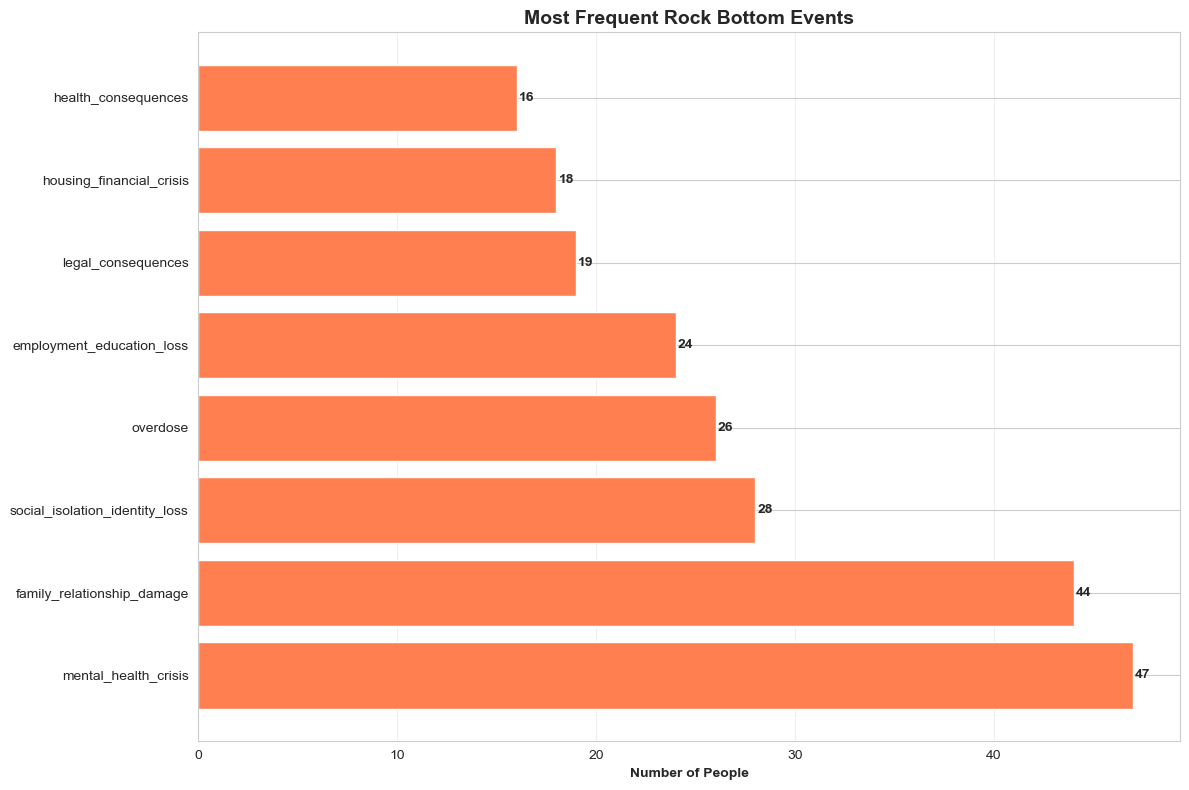

In [58]:
import matplotlib.pyplot as plt
from collections import Counter

# Collect rock bottom events
event_counts = Counter()

for result in results:
    rb = result.get('rock_bottom', {})
    if rb.get('found'):
        for event in rb.get('events', []):
            event_type = event.get('type')
            event_counts[event_type] += 1

# Sort by frequency
sorted_events = sorted(event_counts.items(), key=lambda x: x[1], reverse=True)
events = [e[0] for e in sorted_events]
counts = [e[1] for e in sorted_events]

# Plot
plt.figure(figsize=(12, 8))
plt.barh(events, counts, color='coral')
plt.xlabel('Number of People', fontweight='bold')
plt.title('Most Frequent Rock Bottom Events', fontweight='bold', fontsize=14)
plt.grid(axis='x', alpha=0.3)

# Add count labels
for i, (event, count) in enumerate(zip(events, counts)):
    plt.text(count + 0.1, i, str(count), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

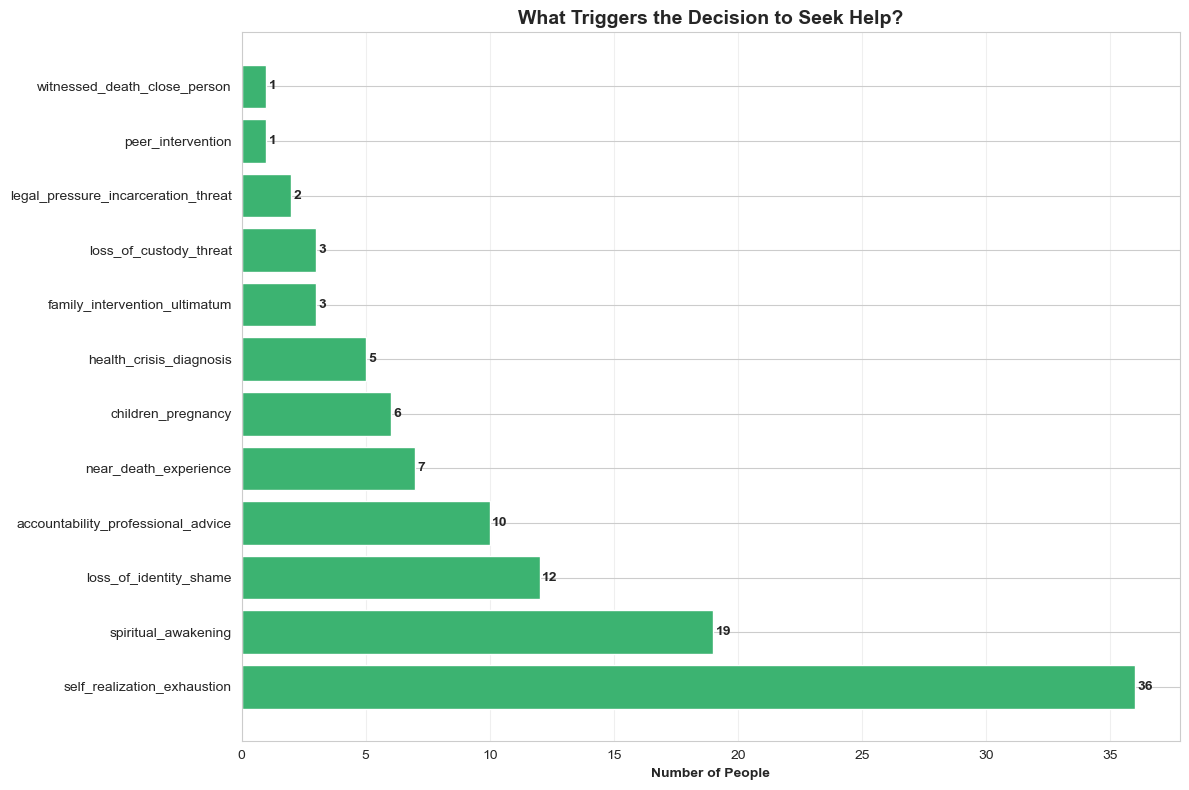

In [63]:
import matplotlib.pyplot as plt
from collections import Counter

# Collect turning point triggers
trigger_counts = Counter()

for result in results:
    tp = result.get('turning_point', {})
    if tp.get('found'):
        for trigger in tp.get('triggers', []):
            if trigger != 'hit_rock_bottom':  # Filter this out
                trigger_counts[trigger] += 1

# Sort by frequency
sorted_triggers = sorted(trigger_counts.items(), key=lambda x: x[1], reverse=True)
triggers = [t[0] for t in sorted_triggers]
counts = [t[1] for t in sorted_triggers]

# Plot
plt.figure(figsize=(12, 8))
plt.barh(triggers, counts, color='mediumseagreen')
plt.xlabel('Number of People', fontweight='bold')
plt.title('What Triggers the Decision to Seek Help?', fontweight='bold', fontsize=14)
plt.grid(axis='x', alpha=0.3)

# Add count labels
for i, (trigger, count) in enumerate(zip(triggers, counts)):
    plt.text(count + 0.1, i, str(count), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

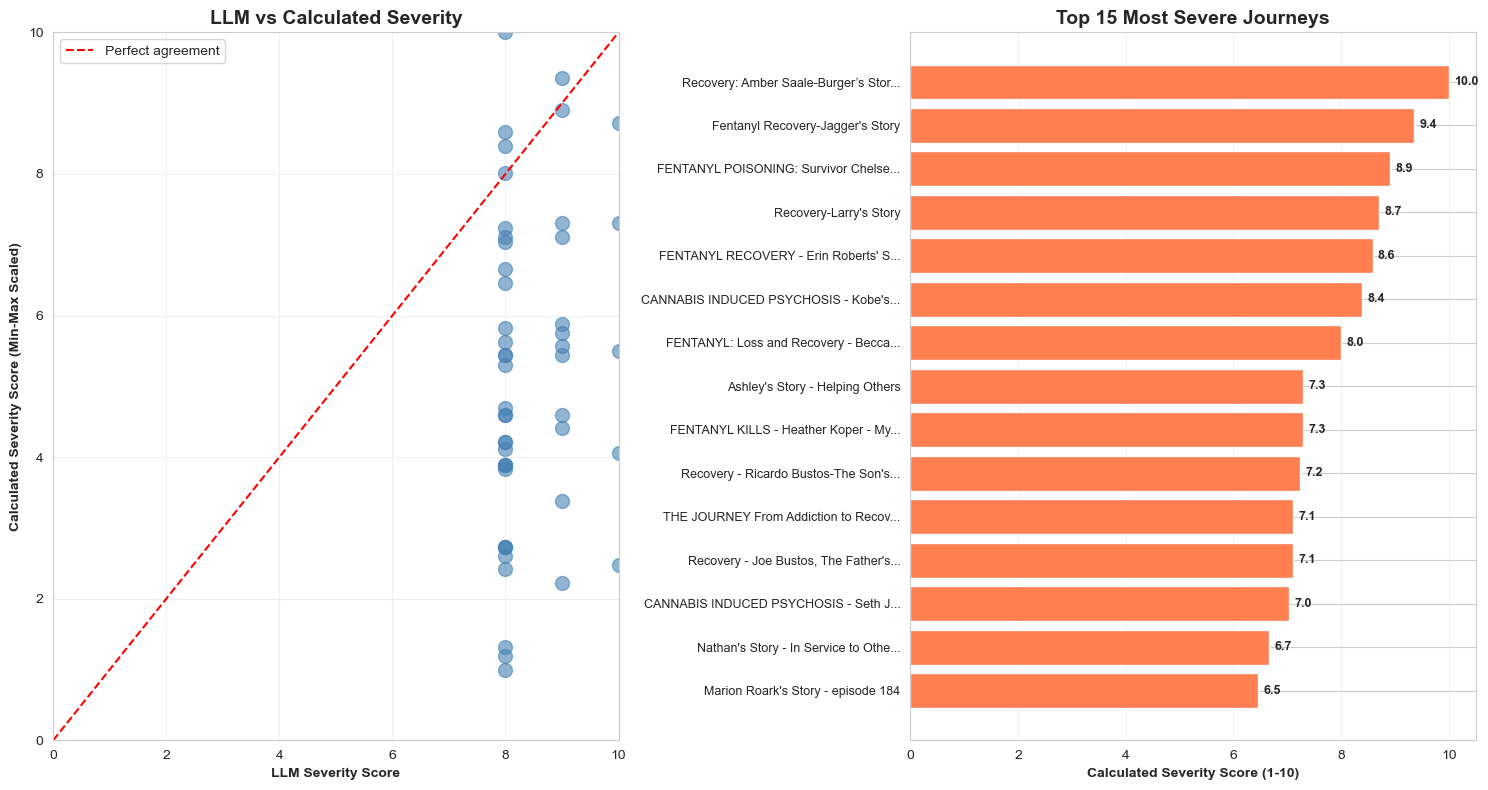


SEVERITY RECALCULATION - MIN-MAX SCALED (1-10)

Min raw score: 2.40
Max raw score: 9.40

Rank  Title                               LLM   Calc  Types  Total  
--------------------------------------------------------------------------------
1     Recovery: Amber Saale-Burger’s St   8.0   10.0  8      8      
2     Fentanyl Recovery-Jagger's Story    9.0   9.4   5      11     
3     FENTANYL POISONING: Survivor Chel   9.0   8.9   4      17     
4     Recovery-Larry's Story              10.0  8.7   7      7      
5     FENTANYL RECOVERY - Erin Roberts'   8.0   8.6   7      7      
6     CANNABIS INDUCED PSYCHOSIS - Kobe   8.0   8.4   7      7      
7     FENTANYL: Loss and Recovery - Bec   8.0   8.0   6      8      
8     Ashley's Story - Helping Others     9.0   7.3   6      6      
9     FENTANYL KILLS - Heather Koper -    10.0  7.3   6      6      
10    Recovery - Ricardo Bustos-The Son   8.0   7.2   3      13     
11    THE JOURNEY From Addiction to Rec   9.0   7.1   6      6      
1

In [89]:
def calculate_severity_score(rock_bottom_data):
    """
    Severity based on:
    - Event type importance (weighted)
    - Frequency of each event type (how many times that type occurred)
    - Diversity bonus (multiple different event types)
    - Normalized to 1-10 using min-max scaling
    """
    
    event_weights = {
        'mental_health_crisis': 1.0,
        'suicidal_ideation_attempt': 1.0,
        'overdose': 0.9,
        'family_relationship_damage': 0.85,
        'social_isolation_identity_loss': 0.85,
        'legal_consequences': 0.7,
        'housing_financial_crisis': 0.7,
        'health_consequences': 0.6,
        'employment_education_loss': 0.6,
    }
    
    if not rock_bottom_data.get('found'):
        return 0
    
    events = rock_bottom_data.get('events', [])
    if not events:
        return 0
    
    # Step 1: Group by event type and count occurrences
    event_type_counts = {}
    for event in events:
        event_type = event.get('type')
        count = event.get('count', 1)
        event_type_counts[event_type] = event_type_counts.get(event_type, 0) + count
    
    # Step 2: Calculate weighted score accounting for frequency
    weighted_score = 0
    for event_type, total_count in event_type_counts.items():
        weight = event_weights.get(event_type, 0.5)
        # Frequency multiplier: caps at 3x
        frequency_multiplier = min(1 + (total_count - 1) * 0.5, 5.0)
        weighted_score += weight * frequency_multiplier
    
    # Step 3: Diversity bonus
    num_unique_types = len(event_type_counts)
    diversity_bonus = num_unique_types * 0.4
    
    # Step 4: Raw score (before scaling)
    raw_score = weighted_score + diversity_bonus
    
    return raw_score


# Calculate all severity scores
results_with_severity = []

for result in results:
    rb = result.get('rock_bottom', {})
    if rb.get('found'):
        raw_severity = calculate_severity_score(rb)
        
        # Get event details
        events = rb.get('events', [])
        event_type_counts = {}
        for event in events:
            event_type = event.get('type')
            count = event.get('count', 1)
            event_type_counts[event_type] = event_type_counts.get(event_type, 0) + count
        
        results_with_severity.append({
            'title': result.get('title'),
            'llm_severity': rb.get('severity_score'),
            'raw_severity': raw_severity,
            'unique_types': len(event_type_counts),
            'total_events': sum(event_type_counts.values()),
        })

df_severity = pd.DataFrame(results_with_severity)

# Step 5: Min-max scaling to 1-10
min_raw = df_severity['raw_severity'].min()
max_raw = df_severity['raw_severity'].max()

df_severity['calculated_severity'] = 1 + (df_severity['raw_severity'] - min_raw) / (max_raw - min_raw) * 9

df_severity = df_severity.sort_values('calculated_severity', ascending=False)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot 1: LLM vs Calculated
ax1 = axes[0]
ax1.scatter(df_severity['llm_severity'], df_severity['calculated_severity'], 
           alpha=0.6, s=100, color='steelblue')
ax1.plot([0, 10], [0, 10], 'r--', label='Perfect agreement')
ax1.set_xlabel('LLM Severity Score', fontweight='bold')
ax1.set_ylabel('Calculated Severity Score (Min-Max Scaled)', fontweight='bold')
ax1.set_title('LLM vs Calculated Severity', fontweight='bold', fontsize=14)
ax1.legend()
ax1.grid(alpha=0.3)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)

# Plot 2: Top 15 by calculated severity
ax2 = axes[1]
top_15 = df_severity.head(15)
y_pos = range(len(top_15))
bars = ax2.barh(y_pos, top_15['calculated_severity'], color='coral')
ax2.set_yticks(y_pos)
ax2.set_yticklabels([title[:35] + '...' if len(title) > 35 else title 
                      for title in top_15['title']], fontsize=9)
ax2.set_xlabel('Calculated Severity Score (1-10)', fontweight='bold')
ax2.set_title('Top 15 Most Severe Journeys', fontweight='bold', fontsize=14)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

for i, (bar, score) in enumerate(zip(bars, top_15['calculated_severity'])):
    ax2.text(score + 0.1, i, f'{score:.1f}', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# Print comparison
print("\n" + "="*80)
print("SEVERITY RECALCULATION - MIN-MAX SCALED (1-10)")
print("="*80)
print(f"\nMin raw score: {min_raw:.2f}")
print(f"Max raw score: {max_raw:.2f}\n")
print(f"{'Rank':<5} {'Title':<35} {'LLM':<5} {'Calc':<5} {'Types':<6} {'Total':<7}")
print("-" * 80)

for rank, row in enumerate(df_severity.head(20).itertuples(), 1):
    print(f"{rank:<5} {row.title[:33]:<35} {row.llm_severity:<5.1f} {row.calculated_severity:<5.1f} {row.unique_types:<6} {row.total_events:<7}")


# Sentiment Analysis using DistilBERT to see who's had the highest Recovery Momentum 

Device set to use cpu


Calculating recovery momentum for all 51 people...

✓ 1/51: Recovery - Honesty's Story... 
✓ 2/51: David Hill's Story - episode 171... 
✓ 3/51: Rebuilding a future... 
✓ 4/51: THE JOURNEY From Addiction to Recovery - Lisa's St... 
✓ 5/51: Mike's Story - The Fires of Recovery... 
✓ 6/51: Keondra's Story - I Had to Listen... 
✓ 7/51: Claire's Story - The change in myself...... 
✓ 8/51: Recovery-TJ's Story... 
✓ 9/51: Nathan's Story - In Service to Others... 
✓ 10/51: FENTANYL KILLS - Maria Simonton, Recovery After Lo... 
✓ 11/51: Addiction to Recovery - Paul's Mission... 
✓ 12/51: THE JOURNEY From Addiction to Recovery - Kara's St... 
✓ 13/51: Recovery - Joe Bustos, The Father's Story... 
✓ 14/51: FENTANYL KILLS - Losing Five - episode 287... 
✓ 15/51: Finding the Path... 
✓ 16/51: Recovery: Amber Saale-Burger’s Story... 
✓ 17/51: THE JOURNEY From Addiction to Recovery - Taylor's ... 
✓ 18/51: Recovery - Ricardo Bustos-The Son's Story... 
✓ 19/51: ADDICTION: Cunning Baffling Powerful... 

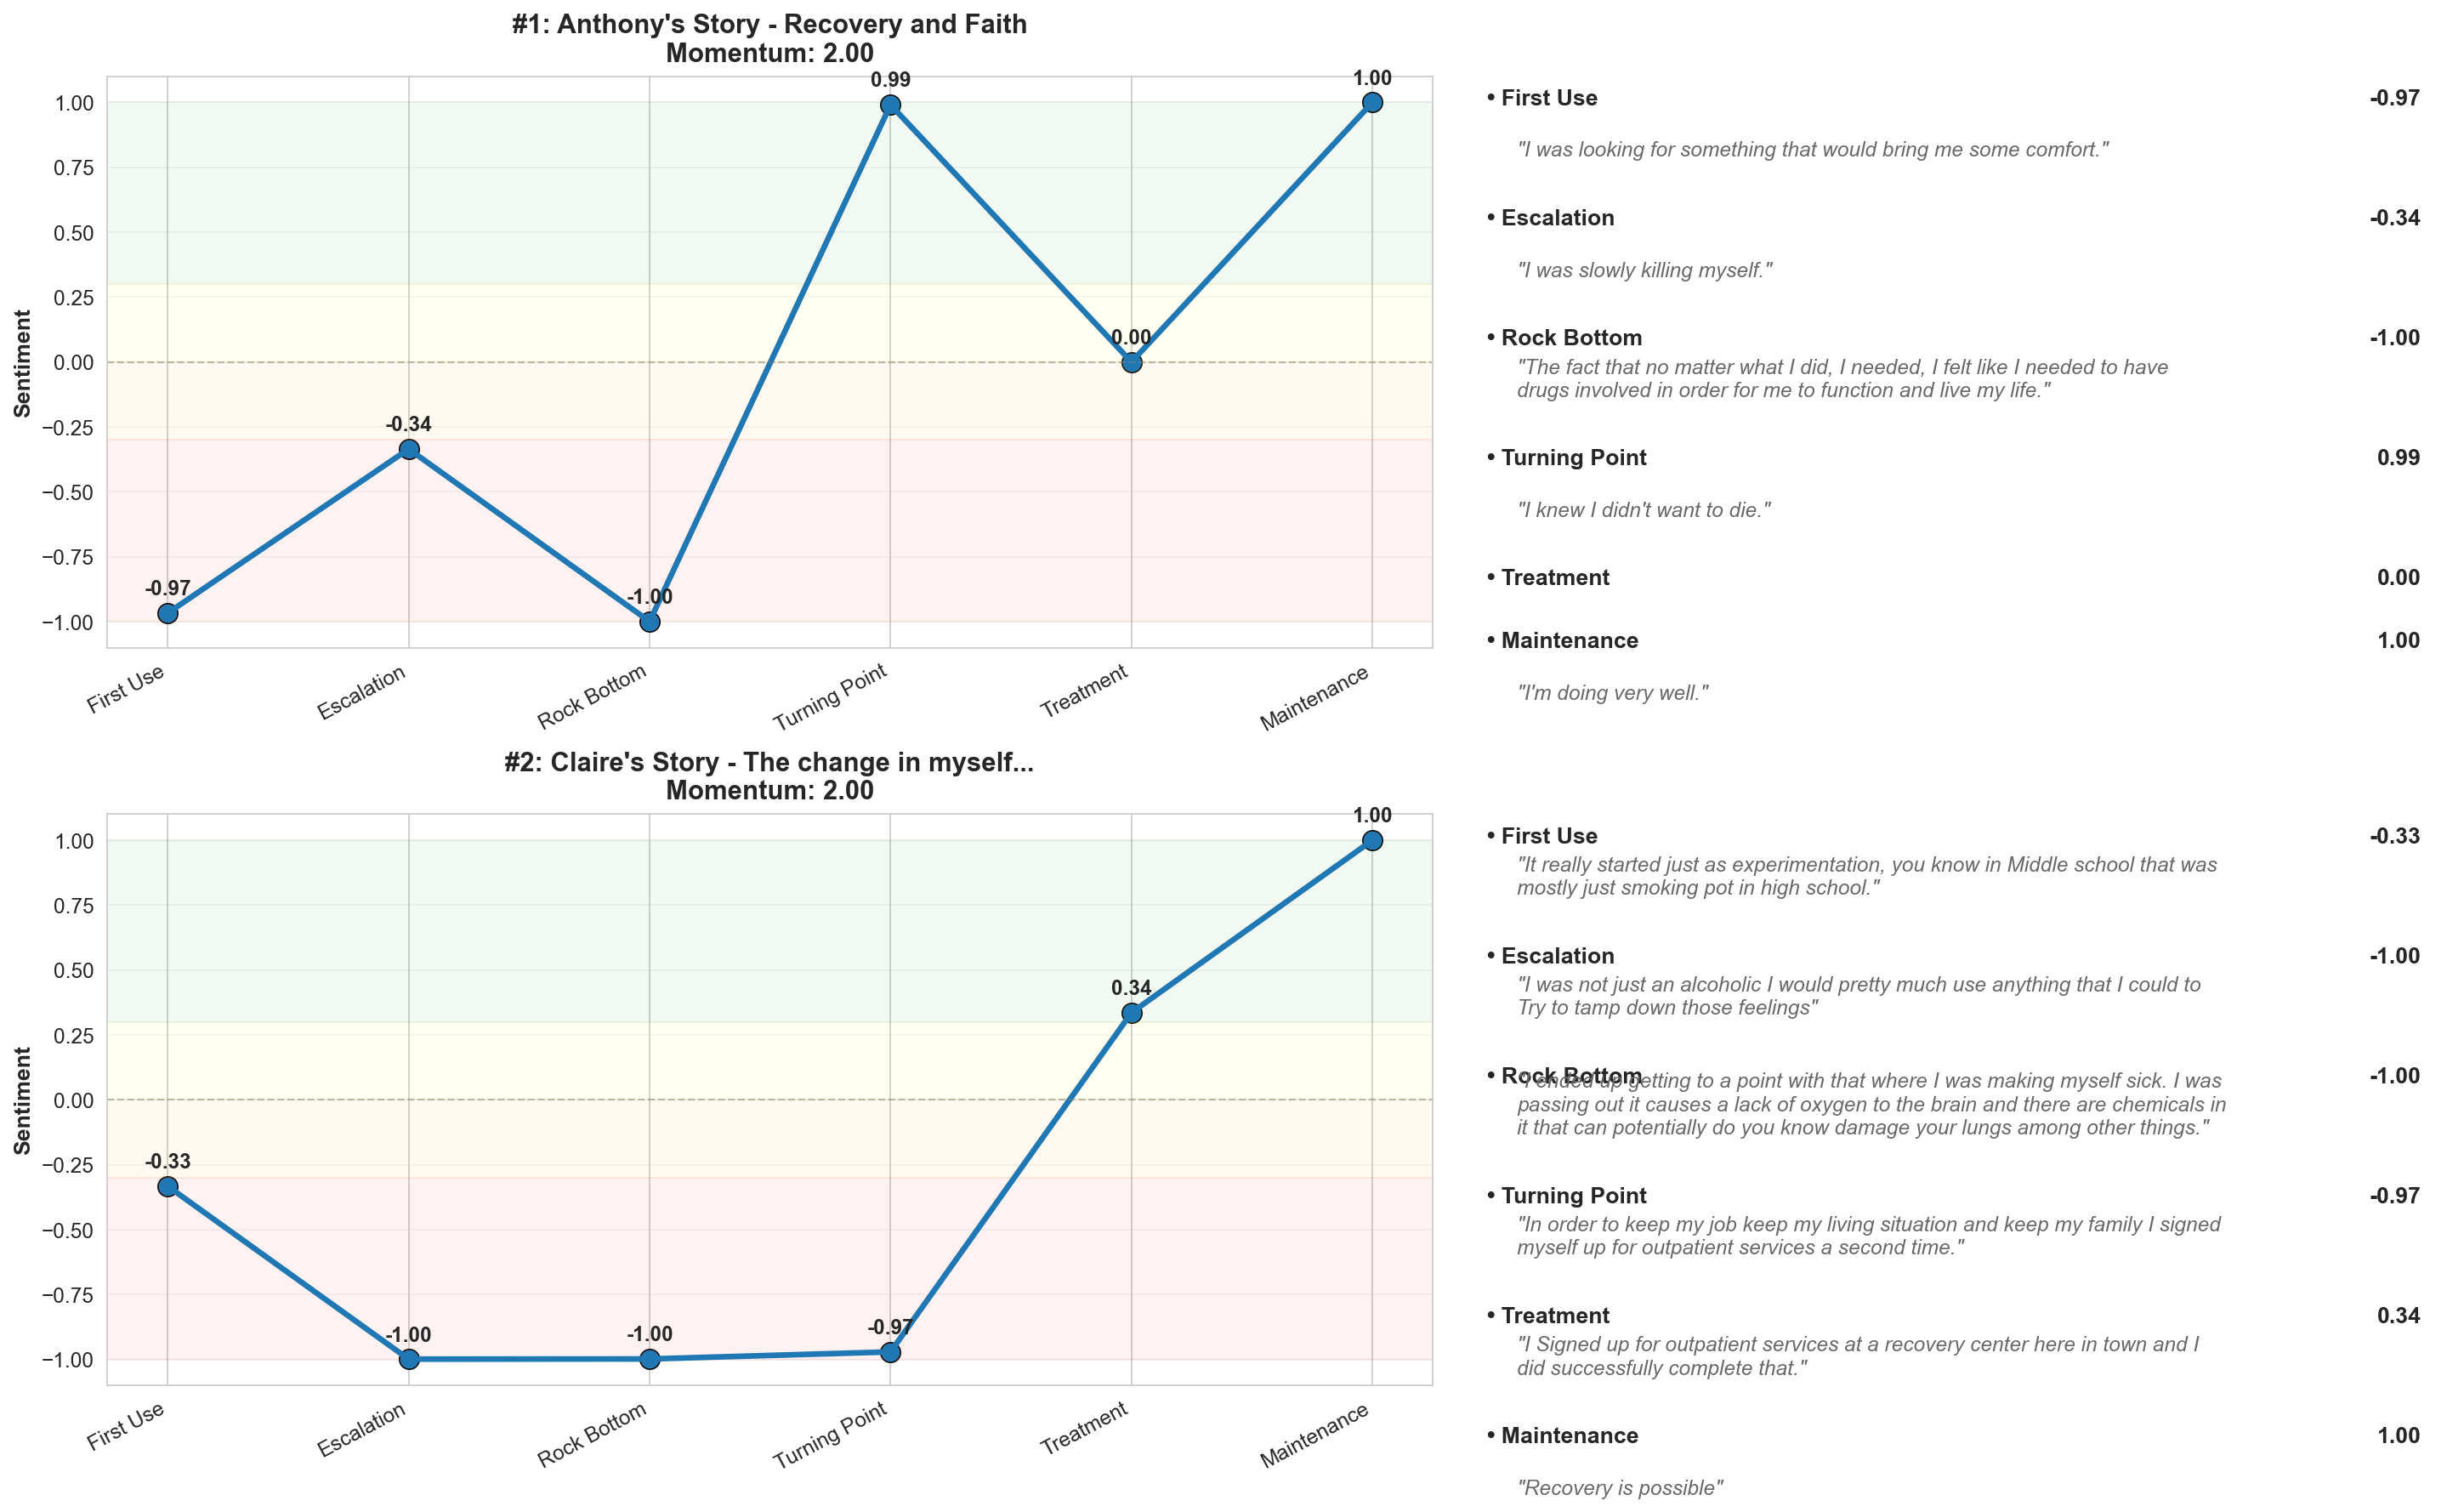

Saved recovery_momentum_page_2.png


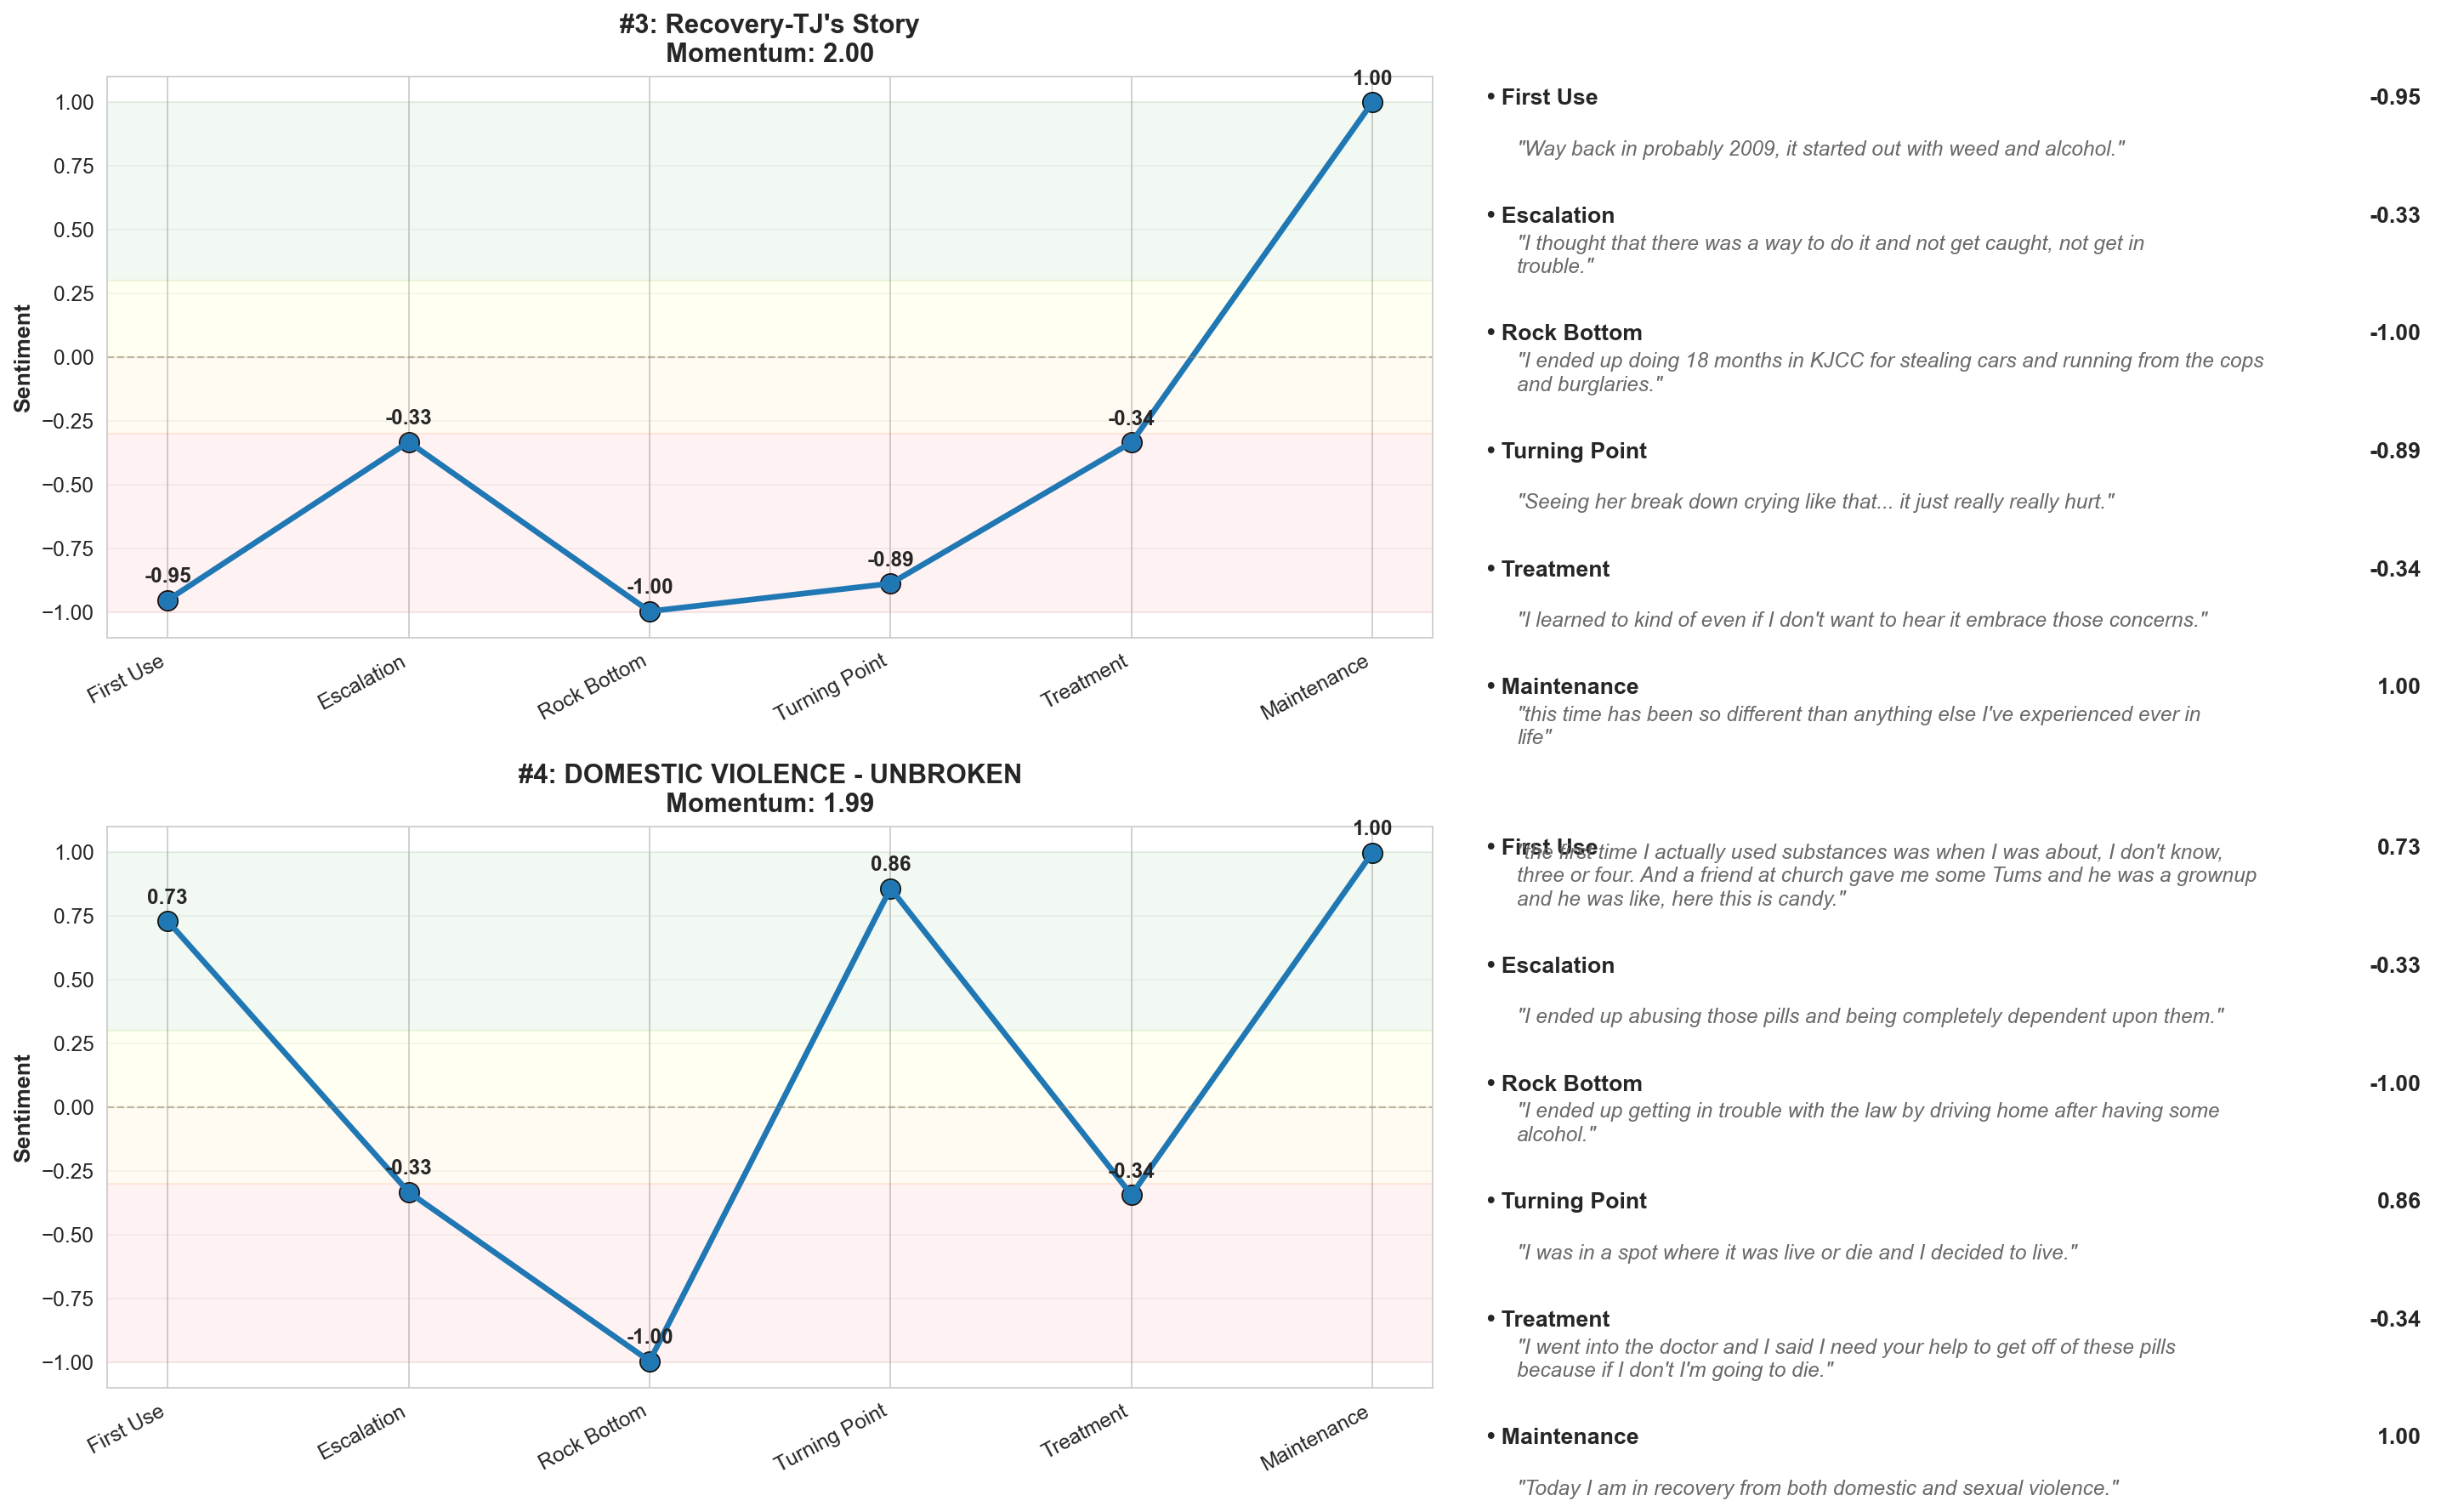

Saved recovery_momentum_page_3.png


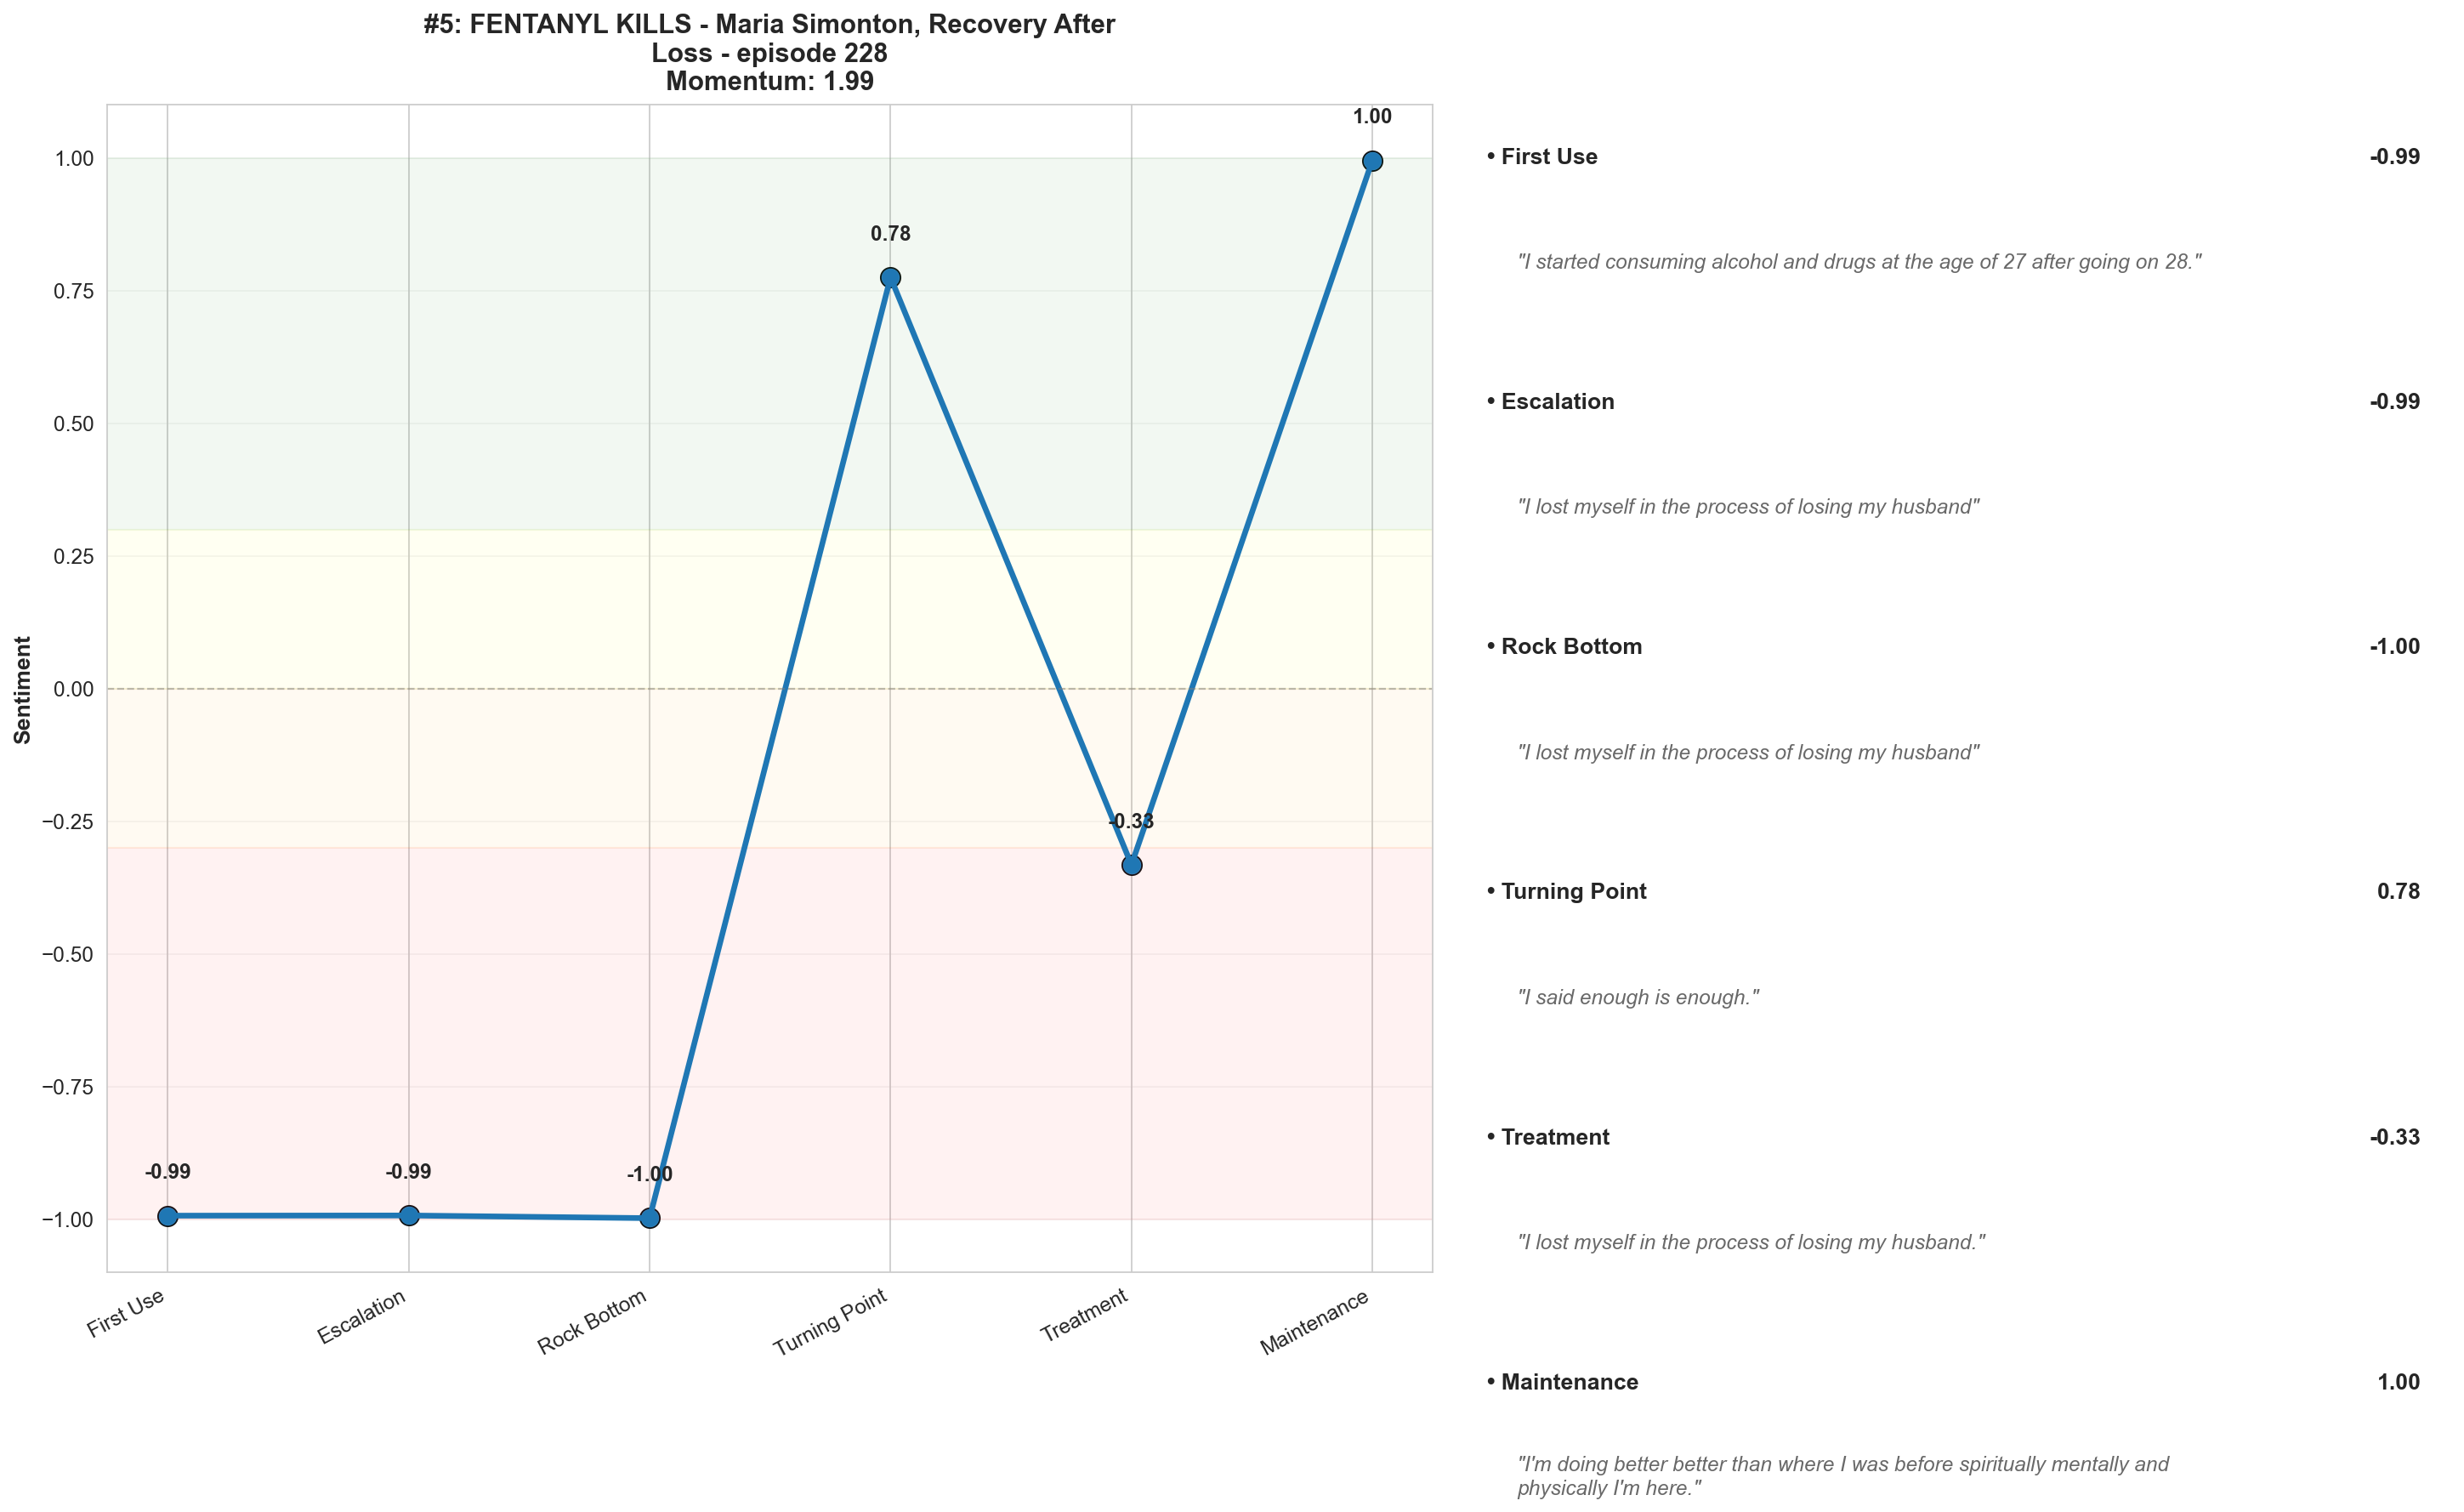


RECOVERY MOMENTUM - TOP 5 HIGHEST IMPROVERS

Rank  Title                                    Lowest Point    Lowest Stage         Maintenance     Momentum       
----------------------------------------------------------------------------------------------------------------------------------
1     Anthony's Story - Recovery and Faith     -1.00           Rock Bottom          1.00            2.00           
2     Claire's Story - The change in myself.   -1.00           Escalation           1.00            2.00           
3     Recovery-TJ's Story                      -1.00           Rock Bottom          1.00            2.00           
4     DOMESTIC VIOLENCE - UNBROKEN             -1.00           Rock Bottom          1.00            1.99           
5     FENTANYL KILLS - Maria Simonton, Recov   -1.00           Rock Bottom          1.00            1.99           



In [108]:
from transformers import pipeline
import matplotlib.pyplot as plt
import numpy as np

# Initialize DistilBERT
sentiment_pipeline = pipeline("sentiment-analysis", 
                            model="distilbert-base-uncased-finetuned-sst-2-english")

def calculate_sentiment_distilbert(text):
    """Calculate sentiment using DistilBERT (-1 to 1)"""
    if not text or not isinstance(text, str):
        return 0
    
    try:
        text = text[:512]
        result = sentiment_pipeline(text)[0]
        label = result['label']
        score = result['score']
        
        if label == 'POSITIVE':
            return score
        else:
            return -score
    except:
        return 0


def get_stage_quotes(result, stage_name):
    """Extract quotes from a stage"""
    stage_data = result.get(stage_name, {})
    
    if stage_name in ['first_use', 'escalation', 'treatment', 'maintenance']:
        return stage_data.get('quotes', [])
    elif stage_name == 'rock_bottom':
        events = stage_data.get('events', [])
        return [e.get('quote') for e in events if e.get('quote')]
    elif stage_name == 'turning_point':
        quotes = stage_data.get('quotes', [])
        if stage_data.get('quote_moment'):
            quotes.insert(0, stage_data.get('quote_moment'))
        return quotes
    return []


def calculate_stage_sentiment_distilbert(result, stage_name):
    """Calculate average sentiment for a stage"""
    quotes = get_stage_quotes(result, stage_name)
    if not quotes:
        return 0
    
    sentiments = []
    for quote in quotes:
        if quote and isinstance(quote, str) and len(quote) > 0:
            sentiment = calculate_sentiment_distilbert(quote)
            sentiments.append(sentiment)
    
    return np.mean(sentiments) if sentiments else 0


# Calculate recovery momentum for all 51 people
stages = ['first_use', 'escalation', 'rock_bottom', 'turning_point', 'treatment', 'maintenance']
stage_labels = ['First Use', 'Escalation', 'Rock Bottom', 'Turning Point', 'Treatment', 'Maintenance']

all_journeys = []

print("Calculating recovery momentum for all 51 people...\n")

for idx, result in enumerate(results, 1):
    print(f"  {idx}/51: {result.get('title')[:50]}...", end=" ", flush=True)
    
    sentiments = []
    for stage in stages:
        sentiment = calculate_stage_sentiment_distilbert(result, stage)
        sentiments.append(sentiment)
    
    # Calculate metrics
    lowest_point = min(sentiments)
    lowest_idx = sentiments.index(lowest_point)
    maintenance_sentiment = sentiments[5]
    
    # Recovery momentum: improvement from lowest point to maintenance
    recovery_momentum = maintenance_sentiment - lowest_point
    
    all_journeys.append({
        'title': result.get('title'),
        'sentiments': sentiments,
        'lowest_point': lowest_point,
        'lowest_stage': stage_labels[lowest_idx],
        'maintenance': maintenance_sentiment,
        'recovery_momentum': recovery_momentum,
        'result': result
    })
    
    print("✓")

# Sort by recovery momentum (highest first)
all_journeys.sort(key=lambda x: x['recovery_momentum'], reverse=True)

# Get top 5
top_5_recoverers = all_journeys[:5]

print(f"\n✓ Top 5 with highest recovery momentum:\n")
for rank, journey in enumerate(top_5_recoverers, 1):
    print(f"{rank}. {journey['title']}")
    print(f"   Lowest: {journey['lowest_point']:.2f} at {journey['lowest_stage']}")
    print(f"   Current: {journey['maintenance']:.2f}")
    print(f"   Recovery Momentum: {journey['recovery_momentum']:.2f}\n")



# ========================== PAGINATED VISUALS (readable) ==========================
import matplotlib.pyplot as plt
import numpy as np
import textwrap

# how many stories per page (2 = most readable; use 3 if you want fewer pages)
PER_PAGE = 2
FIGSIZE  = (18, 11)   # per-page size (inches)
DPI      = 160

# fonts
TITLE_FS   = 22
AXTITLE_FS = 14
BASE_FS    = 12
TICK_FS    = 11
QUOTE_FS   = 11

plt.rcParams.update({
    "font.size": BASE_FS,
    "axes.titlesize": AXTITLE_FS,
    "axes.labelsize": BASE_FS,
    "xtick.labelsize": TICK_FS,
    "ytick.labelsize": TICK_FS,
})

stages = ['first_use', 'escalation', 'rock_bottom', 'turning_point', 'treatment', 'maintenance']
stage_labels = ['First Use', 'Escalation', 'Rock Bottom', 'Turning Point', 'Treatment', 'Maintenance']

def _wrap(s, w): 
    return textwrap.fill((s or "").strip(), width=w)

def draw_page(items, page_idx):
    rows = len(items)
    plt.close('all')
    fig = plt.figure(figsize=FIGSIZE, dpi=DPI, constrained_layout=True)
    gs = fig.add_gridspec(rows, 2, width_ratios=[1.6, 1.2])

    #fig.suptitle(f"Top Recovery Momentum – Sentiment Trajectories (Page {page_idx})",
     #            fontsize=TITLE_FS, fontweight='bold', y=0.995)

    for r, journey in enumerate(items):
        # -------- Left: trajectory --------
        ax_left = fig.add_subplot(gs[r, 0])
        x = np.arange(len(stages))
        y = journey['sentiments']

        ax_left.plot(x, y, marker='o', linewidth=3, markersize=8)
        ax_left.scatter(x, y, s=110, alpha=0.9, edgecolors='black', linewidth=0.8)

        for i, s in enumerate(y):
            ax_left.text(i, s + 0.07, f"{s:.2f}", ha='center', fontweight='bold', fontsize=TICK_FS)

        ax_left.axhline(0, color='gray', ls='--', lw=1, alpha=0.5)
        ax_left.set_xticks(x)
        ax_left.set_xticklabels(stage_labels, rotation=28, ha='right')
        ax_left.set_ylim(-1.1, 1.1)
        ax_left.grid(axis='y', alpha=0.2)
        ax_left.set_ylabel('Sentiment', fontweight='bold')

        # subtle background bands
        ax_left.axhspan(-1, -0.3, alpha=0.05, color='red')
        ax_left.axhspan(-0.3, 0, alpha=0.05, color='orange')
        ax_left.axhspan(0, 0.3, alpha=0.05, color='yellow')
        ax_left.axhspan(0.3, 1, alpha=0.05, color='green')

        title_wrapped = _wrap(journey['title'], 48)
        ax_left.set_title(f"#{(page_idx-1)*PER_PAGE + r + 1}: {title_wrapped}\n"
                          f"Momentum: {journey['recovery_momentum']:.2f}",
                          fontweight='bold', pad=8)

        # -------- Right: quotes --------
        ax_right = fig.add_subplot(gs[r, 1])
        ax_right.set_xlim(0, 1); ax_right.set_ylim(0, 1); ax_right.axis('off')

        y_pos = 0.95
        res = journey['result']
        for st, st_label, s in zip(stages, stage_labels, y):
            ax_right.text(0.03, y_pos, f"• {st_label}",
                          fontsize=BASE_FS, fontweight='bold', transform=ax_right.transAxes)
            ax_right.text(0.97, y_pos, f"{s:.2f}",
                          fontsize=BASE_FS, fontweight='bold', transform=ax_right.transAxes, ha='right')
            y_pos -= 0.09

            qs = get_stage_quotes(res, st)
            if qs:
                q = qs[0]
                if isinstance(q, str) and q:
                    q_wrapped = _wrap(q, 78)
                    ax_right.text(0.06, y_pos, f'"{q_wrapped}"',
                                  fontsize=QUOTE_FS, style='italic',
                                  transform=ax_right.transAxes, color='dimgray', linespacing=1.25)
                    y_pos -= 0.10
            y_pos -= 0.02

    out_png = f"recovery_momentum_page_{page_idx}.png"
    fig.savefig(out_png, dpi=DPI, bbox_inches="tight")
    print(f"Saved {out_png}")
    plt.show()

# ---- paginate through the top 5 ----
pages = [top_5_recoverers[i:i+PER_PAGE] for i in range(0, len(top_5_recoverers), PER_PAGE)]
for p_idx, chunk in enumerate(pages, 1):
    draw_page(chunk, p_idx)

# ======================== END PAGINATED VISUALS =========================





# Print summary table
print("\n" + "="*130)
print("RECOVERY MOMENTUM - TOP 5 HIGHEST IMPROVERS")
print("="*130)
print(f"\n{'Rank':<5} {'Title':<40} {'Lowest Point':<15} {'Lowest Stage':<20} {'Maintenance':<15} {'Momentum':<15}")
print("-" * 130)

for rank, journey in enumerate(top_5_recoverers, 1):
    title = journey['title'][:38]
    print(f"{rank:<5} {title:<40} {journey['lowest_point']:<15.2f} {journey['lowest_stage']:<20} {journey['maintenance']:<15.2f} {journey['recovery_momentum']:<15.2f}")

print("\n" + "="*130)

# Finding the Most Common Paths

In [97]:
from itertools import product
from collections import Counter

def extract_stage_values(result, stage_name):
    """Extract all values from a specific stage"""
    stage_data = result.get(stage_name, {})
    
    if stage_name == 'first_use':
        return stage_data.get('reasons', [])
    elif stage_name == 'escalation':
        return stage_data.get('reasons', [])
    elif stage_name == 'rock_bottom':
        # For rock_bottom, extract unique event types
        events = stage_data.get('events', [])
        return list(set([e.get('type') for e in events]))
    elif stage_name == 'turning_point':
        # Filter out the generic "hit_rock_bottom" value
        triggers = stage_data.get('triggers', [])
        filtered_triggers = [t for t in triggers if t != 'hit_rock_bottom']
        return filtered_triggers
    elif stage_name == 'treatment':
        return stage_data.get('types', [])
    elif stage_name == 'maintenance':
        return stage_data.get('factors', [])
    
    return []

def generate_pathways(results):
    """Generate all possible pathways for each person, then find top 5"""
    
    stages = ['first_use', 'escalation', 'rock_bottom', 'turning_point', 'treatment', 'maintenance']
    
    # Collect all pathways
    all_paths = []
    
    for result in results:
        # Extract values at each stage
        stage_values = {}
        for stage in stages:
            values = extract_stage_values(result, stage)
            stage_values[stage] = values if values else ['none']
        
        # Generate all combinations (Cartesian product)
        combinations = product(
            stage_values['first_use'],
            stage_values['escalation'],
            stage_values['rock_bottom'],
            stage_values['turning_point'],
            stage_values['treatment'],
            stage_values['maintenance']
        )
        
        # Add each path
        for path in combinations:
            all_paths.append(path)
    
    # Count path frequencies
    path_counts = Counter(all_paths)
    
    # Get top 5
    top_5_paths = path_counts.most_common(5)
    
    return top_5_paths, path_counts

# Run analysis
top_5_paths, all_path_counts = generate_pathways(results)

print("\n" + "="*100)
print("FULL JOURNEY SEQUENCING - TOP 5 MOST COMMON PATHWAYS")
print("="*100)
print("\nPathway: first_use → escalation → rock_bottom → turning_point → treatment → maintenance\n")

for rank, (path, frequency) in enumerate(top_5_paths, 1):
    path_str = " → ".join(path)
    print(f"{rank}. {path_str}  [{frequency}]")

print("="*100)


FULL JOURNEY SEQUENCING - TOP 5 MOST COMMON PATHWAYS

Pathway: first_use → escalation → rock_bottom → turning_point → treatment → maintenance

1. self_medication_escape_coping → no_other_coping_strategies → mental_health_crisis → self_realization_exhaustion → inpatient_rehab → support_network  [8]
2. boredom_lack_alternatives → no_other_coping_strategies → mental_health_crisis → self_realization_exhaustion → inpatient_rehab → support_network  [8]
3. self_medication_escape_coping → loss_of_control → family_relationship_damage → self_realization_exhaustion → twelve_step_meetings → helping_others  [7]
4. self_medication_escape_coping → loss_of_control → family_relationship_damage → self_realization_exhaustion → twelve_step_meetings → support_network  [7]
5. self_medication_escape_coping → loss_of_control → overdose → self_realization_exhaustion → twelve_step_meetings → helping_others  [7]


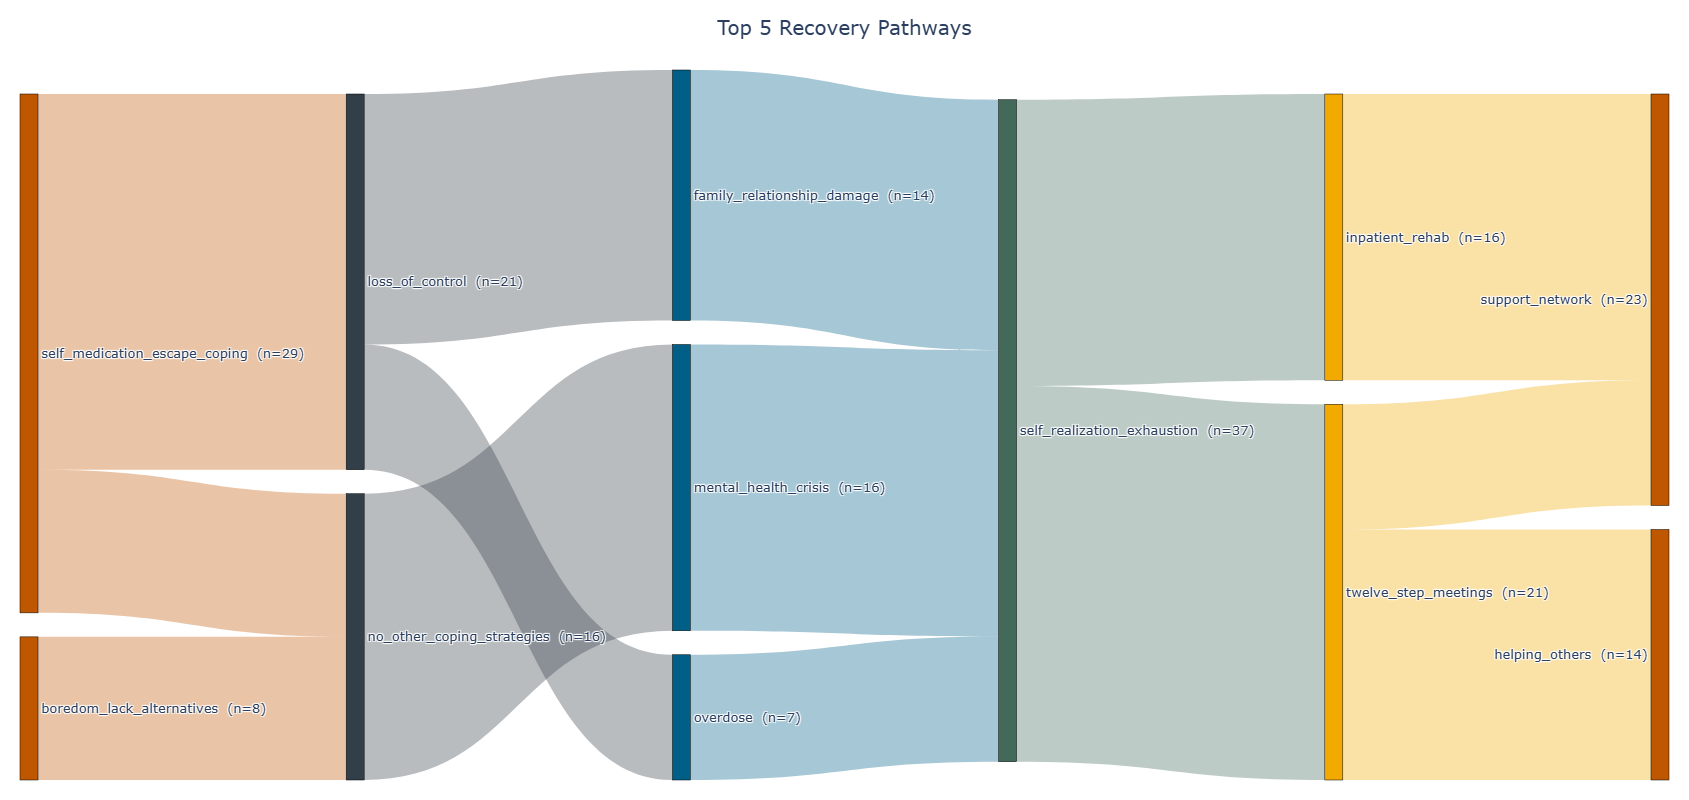

In [106]:
#PLOTTING THE TOP 5 PATHWAYS

import plotly.graph_objects as go
from collections import defaultdict, Counter

stages = ['first_use','escalation','rock_bottom','turning_point','treatment','maintenance']
stage_colors = {
    'first_use':      '#BF5700',
    'escalation':     '#333F48',
    'rock_bottom':    '#005F86',
    'turning_point':  '#43695B',
    'treatment':      '#F2A900',
    'maintenance':    '#BF5700',
}

# ---------- nodes & links ----------
nodes, labels, colors = {}, [], []
def node_id(stage_idx, val):
    key = (stage_idx, val)
    if key not in nodes:
        nodes[key] = len(nodes)
        labels.append(val)  # only value name
        colors.append(stage_colors[stages[stage_idx]])
    return nodes[key]

# aggregate counts across your top_5_paths
link_counts = defaultdict(int)
for path, count in top_5_paths:
    for i in range(len(stages)-1):
        a = node_id(i,   path[i])
        b = node_id(i+1, path[i+1])
        link_counts[(a,b)] += count

# compute node totals (sum of incident links) for display
node_out = Counter()  # sum of outgoing counts
node_in  = Counter()  # sum of incoming counts
for (a,b), v in link_counts.items():
    node_out[a] += v
    node_in[b]  += v

# build link arrays + customdata = % of source flow
sources, targets, values, customdata, hoverlabels = [], [], [], [], []
for (a,b), v in link_counts.items():
    sources.append(a)
    targets.append(b)
    values.append(v)
    denom = node_out[a] if node_out[a] else 1
    customdata.append(v / denom)  # % of source going along this link
    hoverlabels.append(f"{labels[a]} → {labels[b]}")

# append totals to node labels (as “(n=…)”)
node_labels_with_n = []
for i, lab in enumerate(labels):
    n_total = max(node_out[i], node_in[i])  # whichever is non-zero at that stage
    suffix = f"  (n={n_total})" if n_total else ""
    node_labels_with_n.append(lab + suffix)

# color links by source node color with translucency
link_colors = []
for s in sources:
    c = colors[s]
    # convert hex to rgba with alpha
    if c.startswith('#'):
        r = int(c[1:3], 16); g = int(c[3:5], 16); b = int(c[5:7], 16)
        link_colors.append(f"rgba({r},{g},{b},0.35)")
    else:
        link_colors.append("rgba(170,170,170,0.35)")

fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    valueformat=".0f",
    node=dict(
        pad=24,
        thickness=18,
        line=dict(color="black", width=0.5),
        label=node_labels_with_n,
        color=colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors,
        customdata=customdata,
        hovertemplate=(
            "<b>%{label}</b><br>"          # source → target
            "Count: <b>%{value}</b><br>"
            "Share of source: <b>%{customdata:.0%}</b>"
            "<extra></extra>"
        ),
        label=hoverlabels  # used by %{label} in hovertemplate
    )
)])

fig.update_layout(
    title=dict(
        text="Top 5 Recovery Pathways",
        x=0.5, xanchor="center", font=dict(size=20)
    ),
    font=dict(size=13),
    height=800, width=1600,
    margin=dict(l=20, r=20, t=70, b=20),
    paper_bgcolor="white",
)

fig.show()
